# Calculate Automation Probabilities of Jobs on the Swiss Labour Market

## Content
1. [Import Data](#import)
2. [Normalize the Data](#normalize)
3. [Calculate Weighted Sum from Coefficients](#weighted-sum)
4. [Calculate Probability of Automation](#probability)
5. [Display Results](#display)
6. [Save Results](#save)

In [733]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math as m

<a id='import'></a>
## Import Data

In [734]:
# Replace 'filename.csv' with the path to your CSV file
df_swiss_jobs = pd.read_csv('files/switzerland_occupations.csv')
coefficients_outside_95 = pd.read_csv('files/coefficients.csv')
intercept = pd.read_csv('files/intercept.csv').iloc[0, 0]
not_automatable = [item[0] for item in pd.read_csv("files/not_automatable.csv").values.tolist()]

In [735]:
df_swiss_jobs.head(2)

,isco08,Name_de,Berufshauptgruppe,s1,s2,s3,s4,s5,s6,s7,...,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52
0,2655,Schauspieler,2,0.72,0.72,0.69,0.69,0.50,0.50,0.50,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2612,Richter,2,0.81,0.75,0.81,0.72,0.81,0.66,0.56,...,0.0,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [736]:
coefficients_outside_95.head(2)

,id,coefficient
0,a12,-0.809382
1,s6,-0.701232


In [737]:
cols_to_keep = not_automatable
cols_to_keep.extend(['isco08', 'Name_de', 'Berufshauptgruppe'])

# Drop the other columns
df_swiss_jobs = df_swiss_jobs[cols_to_keep]

# Display the first few rows of the DataFrame
df_swiss_jobs.head(2)

,s15,s8,s31,s26,s24,a12,a13,s4,s27,a5,isco08,Name_de,Berufshauptgruppe
0,0.38,0.47,0.0,0.0,0.06,0.47,0.47,0.69,0.0,0.72,2655,Schauspieler,2
1,0.56,0.72,0.0,0.0,0.19,0.78,0.81,0.72,0.0,0.81,2612,Richter,2


<a id='normalize'></a>
## Normalize the Data

In [738]:
# Initialize a scaler
scaler = StandardScaler()

# Define the columns to scale
cols_to_scale = [col for col in df_swiss_jobs.columns if col not in ['isco08', 'Name_de',"Berufshauptgruppe"]]

# Scale only these columns
df_swiss_jobs_scaled = df_swiss_jobs.copy()
df_swiss_jobs_scaled[cols_to_scale] = scaler.fit_transform(df_swiss_jobs[cols_to_scale])

df_swiss_jobs_scaled.head(2)

,s15,s8,s31,s26,s24,a12,a13,s4,s27,a5,isco08,Name_de,Berufshauptgruppe
0,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.339877,-1.090140,1.364145,-0.484664,0.655626,2655,Schauspieler,2
1,1.120839,1.380598,-1.468928,-1.079571,0.150205,1.407552,1.720364,1.632658,-0.484664,1.268358,2612,Richter,2


<a id='weighted-sum'></a>
## Calculate Weighted Sum from Coefficients

In [739]:
# Create a dictionary from the coefficients DataFrame
coef_dict = coefficients_outside_95.set_index('id')['coefficient'].to_dict()

print(coef_dict["s31"])

0.0280082924110774


In [740]:
# calculate weighted sums
ignore_cols = ['Name_de', 'isco08', 'Berufshauptgruppe']
weighted_sums = []

for index, row in df_swiss_jobs_scaled.iterrows():
    sum = 0
    for col_name, col_value in row.items():
        if col_name not in ignore_cols:
            sum += coef_dict[col_name] * col_value
    weighted_sums.append(sum)

# Create a new DataFrame for the weighted sums
df_swiss_jobs_scaled["weighted_sum"] = pd.DataFrame(weighted_sums)

df_swiss_jobs_scaled.head(2)

,s15,s8,s31,s26,s24,a12,a13,s4,s27,a5,isco08,Name_de,Berufshauptgruppe,weighted_sum
0,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.339877,-1.090140,1.364145,-0.484664,0.655626,2655,Schauspieler,2,0.137466
1,1.120839,1.380598,-1.468928,-1.079571,0.150205,1.407552,1.720364,1.632658,-0.484664,1.268358,2612,Richter,2,-1.396630


<a id='probability'></a>
## Calculate Probability of Automation

In [741]:
# Calculate the probabilities
prob_list = [m.exp(x_i + intercept) / (1 + m.exp(x_i + intercept)) for x_i in df_swiss_jobs_scaled['weighted_sum']]

In [742]:
# Add the probabilities to the DataFrame
df_swiss_jobs_scaled['probability'] = prob_list

df_swiss_jobs_scaled.head(5)

,s15,s8,s31,s26,s24,a12,a13,s4,s27,a5,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.339877,-1.090140,1.364145,-0.484664,0.655626,2655,Schauspieler,2,0.137466,0.483377
1,1.120839,1.380598,-1.468928,-1.079571,0.150205,1.407552,1.720364,1.632658,-0.484664,1.268358,2612,Richter,2,-1.396630,0.167896
2,-0.221735,0.655141,0.816395,1.245401,1.181460,0.875792,0.976407,-0.604947,1.623438,0.859870,3115,"Maschinenbautechniker, Techniker im Bereich Sy...",3,-0.543220,0.321431
3,0.225790,1.622417,-1.468928,-1.079571,0.493957,1.141672,1.472378,-0.336434,-0.484664,0.859870,2120,"Mathematiker, Aktuare und Statistiker",2,-0.471668,0.337233
4,0.897077,0.655141,-1.468928,-0.909451,0.150205,0.875792,0.232450,1.901170,-0.484664,0.859870,1222,Führungskräfte in Werbung und Öffentlichkeitsa...,1,-0.903004,0.248433


<a id='display'></a>
## Display Results

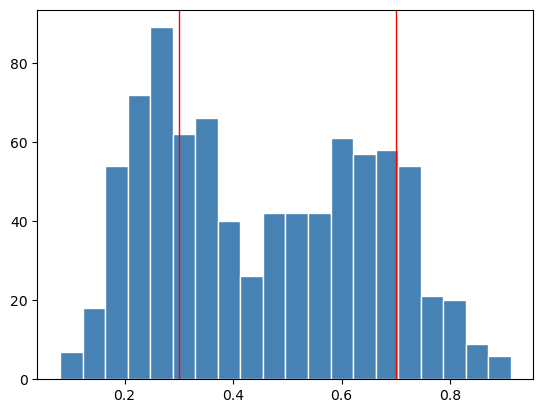

In [743]:
# Get the values
x = df_swiss_jobs_scaled["probability"].values

# Calculate the histogram
hist, bins = np.histogram(x, bins=20)

# Calculate the width and center of the bars
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# Plot the histogram
plt.bar(center, hist, align='center', width=width, color='#4682B4', edgecolor='white')

# Add lines at 0.3 and 0.7
plt.axvline(0.3, color='r', linewidth=1)
plt.axvline(0.7, color='r', linewidth=1)

# Show the plot
plt.show()

In [744]:
# Jobs with probability below 0.3
jobs_below_03 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] <= 0.3]
print(f"Number of jobs with probability below 0.3: {len(jobs_below_03)}")

# Jobs with probability between 0.3 and 0.7
jobs_between_03_and_07 = df_swiss_jobs_scaled[(df_swiss_jobs_scaled['probability'] > 0.3) & (df_swiss_jobs_scaled['probability'] <= 0.7)]
print(f"Number of jobs with probability between 0.3 and 0.7: {len(jobs_between_03_and_07)}")

# Jobs with probability above 0.7
jobs_above_07 = df_swiss_jobs_scaled[df_swiss_jobs_scaled['probability'] > 0.7]
print(f"Number of jobs with probability above 0.7: {len(jobs_above_07)}")

Number of jobs with probability below 0.3: 258
Number of jobs with probability between 0.3 and 0.7: 473
Number of jobs with probability above 0.7: 115


In [745]:
df_swiss_jobs_scaled.head(2)

,s15,s8,s31,s26,s24,a12,a13,s4,s27,a5,isco08,Name_de,Berufshauptgruppe,weighted_sum,probability
0,-0.221735,-0.634561,-1.468928,-1.079571,-1.339385,-1.339877,-1.090140,1.364145,-0.484664,0.655626,2655,Schauspieler,2,0.137466,0.483377
1,1.120839,1.380598,-1.468928,-1.079571,0.150205,1.407552,1.720364,1.632658,-0.484664,1.268358,2612,Richter,2,-1.396630,0.167896


<a id='save'></a>
## Save Results

In [746]:
df_probabilities = df_swiss_jobs_scaled[['Name_de', 'Berufshauptgruppe', 'probability', "isco08"]].copy()
df_pytorch_model = df_swiss_jobs_scaled.drop(columns=["weighted_sum"])

In [747]:
df_probabilities['probability'] = df_probabilities['probability'].round(4)
df_probabilities.to_csv('files/switzerland_probabilities.csv', index=False)